# Construyendo el primer modelo predictivo

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ymeza@ubiobio.cl

**Fecha de Creación:** Octubre de 2025  
**Versión:** 1.0  
  

---

## Descripción

Este notebook muestra la construcción del primer modelo predictivo de una variable continua, es decir, un `modelo de regresión`.


Se considera a `CRISP-DM` como la metodología de trabajo para desarrollar el proyecto.


Dentro del flujo de `CRISP-DM` se automatizan la fases de preparación y modelado a ravés del uso de `pipeline de scikit-learn`

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)

Para verificar si está instalado pandas, numpy o matplotlib ejecutar:

```bash
pip show pandas
```

```bash
pip show numpy
```

In [ ]:
# Descargar el archivo y guardarlo en el entorno
!wget https://raw.githubusercontent.com/JaznaLaProfe/InteligenciaArtificial/master/data/inmuebles.csv

--2025-10-02 21:54:50--  https://raw.githubusercontent.com/JaznaLaProfe/InteligenciaArtificial/master/data/inmuebles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190854 (186K) [text/plain]
Saving to: ‘inmuebles.csv’

inmuebles.csv       100%[===================>] 186.38K  --.-KB/s    in 0.004s  

2025-10-02 21:54:50 (48.0 MB/s) - ‘inmuebles.csv’ saved [190854/190854]



# Contexto del negocio

Una inmobiliaria busca mejorar la eficiencia de su equipo de ventas. Actualmente, los agentes inmobiliarios determinan el precio de venta de una propiedad de forma subjetiva, basándose en experiencia y comparación con inmuebles similares.

El problema:

+ Esto puede llevar a sobrevaloración (tiempo prolongado en el mercado) o subvaloración (pérdida de ingresos).

+ Además, se quiere estandarizar criterios y tener un modelo que pueda ser aplicado automáticamente a nuevas propiedades.

# Objetivo del proyecto

Construir un modelo predictivo que estime el precio de venta de una propiedad en función de sus características (superficie, ubicación, número de habitaciones, entre otras).

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*ELsvhb3RqyZS8phHxo6a3A.png)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer

In [ ]:
data = pd.read_csv('inmuebles.csv')
data.head()

,ID,Superficie_m2,Habitaciones,Baños,Antiguedad,Ubicacion,Estacionamientos,TieneTerraza,PrecioVenta
0,1,103,4,4,31.0,Alta,3.0,No,77691.0
1,2,148,3,2,35.0,Alta,0.0,No,80941.0
2,3,197,6,4,43.0,Media,2.0,No,89893.0
3,4,34,3,2,47.0,Media,3.0,Sí,41221.0
4,5,149,5,4,76.0,Baja,3.0,Sí,93710.0


# Fase 2 - Comprensión de los datos

## Cantidad observaciones y características

In [ ]:
data.shape

(5000, 9)

## Análisis de calidad de los datos

### Existencia de duplicados

In [ ]:
duplicados = data[data.duplicated(keep=False)]
duplicados

,ID,Superficie_m2,Habitaciones,Baños,Antiguedad,Ubicacion,Estacionamientos,TieneTerraza,PrecioVenta


✅ **Comentarios**

---

+ Se aprecia ausencia de filas duplicadas dentro del conjunto de datos.

### Inspección de datos nulos

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                5000 non-null   int64  
 1   Superficie_m2     5000 non-null   int64  
 2   Habitaciones      5000 non-null   int64  
 3   Baños             5000 non-null   int64  
 4   Antiguedad        4809 non-null   float64
 5   Ubicacion         5000 non-null   object 
 6   Estacionamientos  4726 non-null   float64
 7   TieneTerraza      5000 non-null   object 
 8   PrecioVenta       5000 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 351.7+ KB


In [ ]:
# Muestra una tabla con los % de nulos de cada columna
columnas_con_nulos = data.isna().sum()[data.isna().sum() > 0]
porcentaje_nulos = (columnas_con_nulos / data.shape[0]) * 100

resultado = pd.DataFrame({
    "Cantidad Nulos": columnas_con_nulos,
    "Porcentaje Nulos (%)": porcentaje_nulos
}).round(2)


resultado

,Cantidad Nulos,Porcentaje Nulos (%)
Antiguedad,191,3.82
Estacionamientos,274,5.48


✅ **Comentarios**

---

+ Se aprecia que hay 2 variables que contienen valores nulos y se deberán tratar ambas.

+ Para ambos casos, se debe revisar la existencia de atípicos para decidir por la técnica de reemplazo de nulos.

### Análisis de consistencia

In [ ]:
# Revisa los tipos de datos
data.dtypes

,0
ID,int64
Superficie_m2,int64
Habitaciones,int64
Baños,int64
Antiguedad,float64
Ubicacion,object
Estacionamientos,float64
TieneTerraza,object
PrecioVenta,float64


In [ ]:
def ver_negativos(data : pd.DataFrame, columna : str) -> bool:
  return np.sum(data[columna] < 0) > 0

In [ ]:
columnas_a_revision = ["Superficie_m2", "Antiguedad", "Habitaciones", "Baños", "Estacionamientos", "PrecioVenta"]
for columna in columnas_a_revision:
  print(f"{columna :>20} -> {'Inconsistente' if ver_negativos(data, columna) else 'Consistente'}")

       Superficie_m2 -> Inconsistente
          Antiguedad -> Consistente
        Habitaciones -> Consistente
               Baños -> Consistente
    Estacionamientos -> Consistente
         PrecioVenta -> Inconsistente


In [ ]:
data.Superficie_m2.describe()

,Superficie_m2
count,5000.000000
mean,123.534200
std,60.838178
min,-20.000000
25%,94.000000
50%,121.000000
75%,148.000000
max,1095.000000


In [ ]:
np.sum(data.Superficie_m2 < 0)

np.int64(8)

In [ ]:
print(f"Hay {np.sum(data.Superficie_m2 < 0)/data.shape[0]:.4f}% de valores inconsistentes")

Hay 0.0016% de valores inconsistentes


In [ ]:
data.PrecioVenta.describe()

,PrecioVenta
count,5000.000000
mean,52646.625000
std,34524.835607
min,-50191.000000
25%,32240.500000
50%,51038.000000
75%,69064.750000
max,367269.000000


In [ ]:
np.sum(data.PrecioVenta < 0)

np.int64(146)

In [ ]:
print(f"Hay {np.sum(data.PrecioVenta < 0)/data.shape[0]:.2f}% de valores inconsistentes")

Hay 0.03% de valores inconsistentes


✅ **Comentarios**

▶ Se aprecian valores inconsistentes en 2 de las variables: `PrecioVenta` y `Superficie`

▶ Los porcentajes de valores inconsistemtes son bajos por lo que se procede a eliminarlos porque están fuera del contexto del negocio, porque es imposible identificar la fuente del error se decide eliminar

In [ ]:
data.TieneTerraza.unique()

array(['No', 'Sí'], dtype=object)

In [ ]:
data.Ubicacion.unique()

array(['Alta', 'Media', 'Baja'], dtype=object)

### Existencia de valores atípicos

In [ ]:
def buscar_atipicos(data : pd.DataFrame, columna : str) -> pd.DataFrame:
  """
  Busca valores atípicos en una columna.
  """
  # Calcular los límites
  Q1 = data[columna].quantile(0.25)
  Q3 = data[columna].quantile(0.75)
  # Calcula rango intercuartilico
  IQR = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR

  # Filtrar outliers
  return data[(data[columna] < limite_inferior) | (data[columna] > limite_superior)]

def obtener_cantidad_atipicos(data : pd.DataFrame, columnas : np.array) -> dict:
  """
  Obtiene la cantidad de atípicos por cada columna.
  """
  total_atipicos = {}
  for columna in data[columnas]:
    atipicos = buscar_atipicos(data, columna)
    total_atipicos[columna] = atipicos.shape[0]
  return total_atipicos

In [ ]:
atipicos_por_columna = obtener_cantidad_atipicos(data, data.describe().columns)
pd.DataFrame(atipicos_por_columna, index=["Cantidad"]).T

,Cantidad
ID,0
Superficie_m2,60
Habitaciones,0
Baños,0
Antiguedad,0
Estacionamientos,0
PrecioVenta,83


✅ **Comentarios**

---

▶ Dos variables presentan atípicos

#### `Superficie`

In [ ]:
# Visualiza algunos atípicos
buscar_atipicos(data, "Superficie_m2").head()

,ID,Superficie_m2,Habitaciones,Baños,Antiguedad,Ubicacion,Estacionamientos,TieneTerraza,PrecioVenta
80,81,-20,2,1,51.0,Alta,2.0,Sí,31578.0
309,310,246,1,2,58.0,Baja,3.0,Sí,-25060.0
541,542,232,2,3,3.0,Media,2.0,No,18467.0
659,660,239,5,1,64.0,Baja,0.0,No,48143.0
684,685,9,4,1,52.0,Alta,2.0,Sí,75443.0


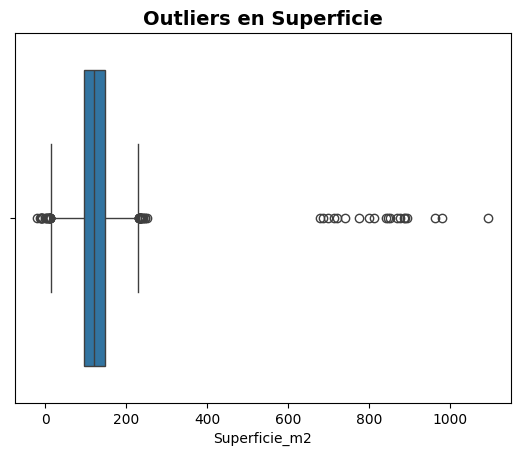

In [ ]:
# Visualización de outliers en superficie
sb.boxplot(x=data["Superficie_m2"])
plt.title("Outliers en Superficie", fontsize=14, fontweight="bold")
plt.show()

## Análisis de datos

### Variable objetivo `PrecioVenta`

In [ ]:
data.PrecioVenta.describe()

,PrecioVenta
count,5000.000000
mean,52646.625000
std,34524.835607
min,-50191.000000
25%,32240.500000
50%,51038.000000
75%,69064.750000
max,367269.000000


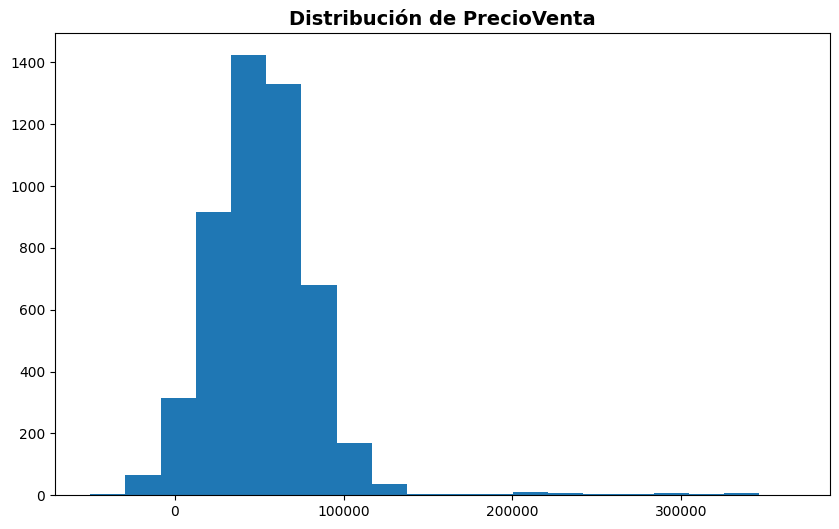

In [ ]:
data.PrecioVenta.hist(bins=20, figsize=(10,6), grid=False)
plt.title("Distribución de PrecioVenta", fontsize=14, fontweight="bold")
plt.show()

### Variables candidatas a ser predictoras

In [ ]:
data.Baños.describe()

,Baños
count,5000.000000
mean,2.504200
std,1.119926
min,1.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,4.000000


✅ **Comentarios**

---

▶ En promedio, las viviendas tienen entre 2 y 3 baños.

▶ Las viviendas con mayor cantidad de baños tienen 4 baños.

▶ El 50% de las viviendas tienen 3 o menos baños.


# Fase 3 - Preparación de datos

## Elimina inconsistencias

In [ ]:
# Detectar inconsistencias
inconsistentes = data[(data["Superficie_m2"] <= 0) | (data["PrecioVenta"] <= 0)]
print("Registros inconsistentes encontrados:")
display(inconsistentes)




Registros inconsistentes encontrados:


,ID,Superficie_m2,Habitaciones,Baños,Antiguedad,Ubicacion,Estacionamientos,TieneTerraza,PrecioVenta
61,62,167,3,2,NaN,Baja,2.0,No,-6459.0
71,72,103,3,4,73.0,Media,2.0,No,-15839.0
80,81,-20,2,1,51.0,Alta,2.0,Sí,31578.0
114,115,190,2,1,41.0,Baja,1.0,No,-4140.0
168,169,123,3,1,54.0,Baja,0.0,No,-402.0
...,...,...,...,...,...,...,...,...,...
4877,4878,148,2,1,46.0,Media,0.0,No,-575.0
4915,4916,157,1,1,75.0,Media,3.0,Sí,-5814.0
4919,4920,115,2,1,56.0,Baja,3.0,No,-7914.0
4920,4921,115,2,2,65.0,Media,3.0,No,-14323.0


In [ ]:
# Opción 1: Eliminar inconsistencias
data_final = data[(data["Superficie_m2"] > 0) & (data["PrecioVenta"] > 0)]

# Opción 2 (solo si sabes que fue error de signo): corregir
# data["Superficie_m2"] = data["Superficie_m2"].abs()
# data["PrecioVenta"] = data["PrecioVenta"].abs()

In [ ]:
print(f"Se han eliminado el {inconsistentes.shape[0]/data.shape[0]:.2f}% de los registros por inconsistencias")

Se han eliminado el 0.03% de los registros por inconsistencias


## Descarta columnas con nulo poder predictivo

In [ ]:
# Elimina ID (no es predictivo)
data_final = data_final.drop(columns=["ID"])

✅ **Automatización de fases 3 y 4**

Las fases de preparación y modelamiento se van a automatizar a traés del uso de un `pipeline`.

Ventajas de usar esta técnica:

+ Se puede encadenar imputación de nulos, codificación de variables categóricas y el modelo.

+ Permite hacer el mismo preprocesamiento en train y test sin errores.

+ Se vuelve **reutilizable** para producción o para predecir sobre nuevos datos.

Posible desventaja:

+ Todo queda encapsulado y no se ve fácilmente cómo quedaron los datos después de cada transformación.

In [ ]:
# Variables
features_num = ["Superficie_m2", "Habitaciones", "Baños", "Antiguedad", "Estacionamientos"]
features_cat = ["Ubicacion", "TieneTerraza"]
target = "PrecioVenta"

X = data_final[features_num + features_cat]
y = data_final[target]

# Preprocesamiento numérico: imputación con mediana
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Preprocesamiento categórico: imputación + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Combina en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("numericas", numeric_transformer, features_num),
        ("categoricas", categorical_transformer, features_cat)
    ]
)

In [ ]:
preprocessor

ColumnTransformer(transformers=[('numericas',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['Superficie_m2', 'Habitaciones', 'Baños',
                                  'Antiguedad', 'Estacionamientos']),
                                ('categoricas',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Ubicacion', 'TieneTerraza'])])

# Fase 4 - Modelamiento

In [ ]:
# Calcula la matriz de correlaciones
correlaciones = data_final.corr(numeric_only=True)

# Ver correlación con la variable objetivo
correlacion_objetivo = correlaciones["PrecioVenta"].sort_values(ascending=False)

correlacion_objetivo

,PrecioVenta
PrecioVenta,1.000000
Baños,0.216374
Habitaciones,0.206255
Superficie_m2,0.009056
Estacionamientos,-0.009534
Antiguedad,-0.165418


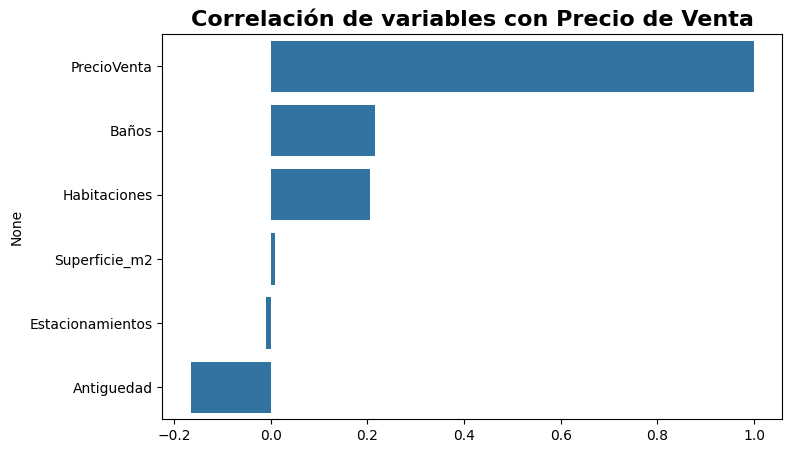

In [ ]:
# Visualización de las correlaciones con el objetivo
plt.figure(figsize=(8,5))
sb.barplot(x=correlacion_objetivo.values, y=correlacion_objetivo.index)
plt.title("Correlación de variables con Precio de Venta",
          fontsize=16, fontweight="bold")
plt.show()

In [ ]:
# Crea el pipeline final (preprocesamiento + modelo)
modelo = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

# Entrenamiento
modelo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numericas',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Superficie_m2',
                                                   'Habitaciones', 'Baños',
                                                   'Antiguedad',
                                                   'Estacionamientos']),
                                                 ('categoricas',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Ubicacion',
                                                   'TieneTerraza'])])),
                ('regressor', LinearRegression())])

In [ ]:
# Variables con las cuales fue entrenado el modelo
modelo.feature_names_in_

array(['Superficie_m2', 'Habitaciones', 'Baños', 'Antiguedad',
       'Estacionamientos', 'Ubicacion', 'TieneTerraza'], dtype=object)

❓ **¿Cómo se puede visualizar el estado de la transformación?**

In [ ]:
# Tomar solo el preprocesamiento (sin el modelo)
X_transformed = modelo.named_steps["preprocessor"].transform(X)

# Convertir a DataFrame para verlo con nombres de columnas
feature_names = modelo.named_steps["preprocessor"].get_feature_names_out()
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)
X_transformed_df.head()


,numericas__Superficie_m2,numericas__Habitaciones,numericas__Baños,numericas__Antiguedad,numericas__Estacionamientos,categoricas__Ubicacion_Baja,categoricas__Ubicacion_Media,categoricas__TieneTerraza_Sí
0,103.0,4.0,4.0,31.0,3.0,0.0,0.0,0.0
1,148.0,3.0,2.0,35.0,0.0,0.0,0.0,0.0
2,197.0,6.0,4.0,43.0,2.0,0.0,1.0,0.0
3,34.0,3.0,2.0,47.0,3.0,0.0,1.0,1.0
4,149.0,5.0,4.0,76.0,3.0,1.0,0.0,1.0


# Fase 5 - Evaluación

In [ ]:
# Funciones para ayudar con la interpretación de las métricas
def interpretacion(algoritmo : str, score : float, contexto : str, caracteristicas : np.array = None):
  """
  Genera la interpretación del rendimiento del modelo
  """
  if not caracteristicas == None:
    return f"""Modelo de regresión {algoritmo}
    {score :.2%} de la variabilidad en {contexto} se puede explicar utilizando: {caracteristicas.values}."""
  else:
    return f"""Modelo de regresión {algoritmo}
      {score :.2%} de la variabilidad en {contexto} se puede explicar utilizando las variables independientes"""

def mae_interpretacion(value : float, contexto : str, modelo : str = "Modelo") -> str:
  """
  Genera la interpretación del MAE
  """
  return f"El modelo '{modelo}' pudo predecir {contexto} en el conjunto de prueba con un error de ± $ {value:.2f} del valor real."

def msle_interpretacion(value : float, contexto : str, modelo : str = "Modelo") -> str:
  """
  Genera la interpretación del MSLE
  """
  return f"El modelo '{modelo}' pudo predecir {contexto} en el conjunto de prueba con un error de ± {value: .2%} del valor real."

In [ ]:
# Predicciones
y_pred = modelo.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Métricas del pipeline ---")
print(f"RMSE: {rmse:,.0f} USD")
print(f"R²: {r2:.3f}")

print(f"MAE: {mae:,.0f} USD")
print(f"MSLE: {msle:.3f}")


--- Métricas del pipeline ---
RMSE: 28,143 USD
R²: 0.183
MAE: 17,469 USD
MSLE: 0.392


In [ ]:
# Guarda las métricas para comparar después con una posible mejora
resultado_inicial = {"RMSE" : rmse, "R2" : r2, "MAE" : mae, "MSLE" : msle}

In [ ]:
nombre_modelo = "Predicción precio propiedad"
print(interpretacion(nombre_modelo, r2, "Precio venta"))

Modelo de regresión Predicción precio propiedad
      18.26% de la variabilidad en Precio venta se puede explicar utilizando las variables independientes


In [ ]:
# Interpretación de las métricas
print(mae_interpretacion(mae, "PrecioVenta", nombre_modelo))
print(msle_interpretacion(msle, "PrecioVenta", nombre_modelo))

El modelo 'Predicción precio propiedad' pudo predecir PrecioVenta en el conjunto de prueba con un error de ± $ 17469.26 del valor real.
El modelo 'Predicción precio propiedad' pudo predecir PrecioVenta en el conjunto de prueba con un error de ±  39.21% del valor real.


In [ ]:
# Obtiene una predicción con nuevos datos
nueva_propiedad = pd.DataFrame({
    "Superficie_m2": [150],
    "Habitaciones": [3],
    "Baños": [2],
    "Antiguedad": [10],
    "Estacionamientos": [1],
    "Ubicacion": ["Media"],
    "TieneTerraza": ["Sí"]
})

precio_estimado = modelo.predict(nueva_propiedad)[0]
print(f"\nPrecio estimado para nueva propiedad: {precio_estimado:,.0f} USD")


Precio estimado para nueva propiedad: 54,624 USD




---



# ⭐ Mejoras del modelo ⭐

Claramente, el resultado es bastante deficiente, la pregunta en este punto es cómo se puede mejorar.

La respuesta, a través de lo que se conoce como `feature engineering` y que consiste en *crear nuevas características a partir de las características originales*

▶ **Precio por m²**

Variable: PrecioPorM2 = PrecioVenta / Superficie_m2

Justificación: muchos agentes inmobiliarios miran el precio por metro cuadrado. Puede ayudar a normalizar propiedades muy grandes o muy pequeñas.

▶ **Relación habitaciones/baños**

Variable: HabitacionesPorBano = Habitaciones / Baños

Justificación: propiedades con muchos baños pero pocas habitaciones pueden ser menos atractivas.

▶ **Propiedades “Premium” según ubicación y terraza**

Variable: EsPremium = 1 si Ubicacion="Alta" y TieneTerraza=1, else 0

Justificación: agrega un indicador de lujo que puede explicar incrementos de precio no lineales.

▶ **Antigüedad categorizada**

Variable: AntiguedadCat → “Nueva” (<10 años), “Media” (10-30), “Vieja” (>30)

Justificación: el precio no disminuye linealmente con la antigüedad, y las categorías pueden capturar la tendencia.

▶ **Número total de baños y estacionamientos**

Variable: Servicios = Baños + Estacionamientos

Justificación: un “score” de comodidades que afecta directamente el valor percibido.

✅ **Posibles aportes**

▶ Permite que variables nuevas tengan mayor correlación con la variable objetivo (`PrecioVenta`) que las originales.

▶ Captura relaciones no lineales que el modelo lineal simple no detecta.

▶ Facilita explicación de negocio, por ejemplo:

+ “Una propiedad premium sube el precio promedio en 40.000 USD”.*

+ “Cada metro cuadrado adicional aumenta el precio en promedio 1.200 USD”.*

In [ ]:
def crear_features(data : pd.DataFrame) -> pd.DataFrame:
  """
  Crea las características a partir de las variables originales.
  """
  data = data.copy()

  # Precio por m2
  data["PrecioPorM2"] = data["PrecioVenta"] / data["Superficie_m2"]

  # Relación habitaciones/baños
  data["HabitacionesPorBano"] = data["Habitaciones"] / data["Baños"]

  # Indicador propiedades premium
  data["EsPremium"] = np.where((data["Ubicacion"]=="Alta") & (data["TieneTerraza"]=="Sí"), 1, 0)

  # Score de servicios
  data["Servicios"] = data["Baños"] + data["Estacionamientos"].fillna(data["Estacionamientos"].mode()[0])

  return data

In [ ]:
# Características a usar en el nuevo modelo
num_features = ["Superficie_m2", "Habitaciones", "Baños", "Antiguedad", "Estacionamientos",
                "PrecioPorM2", "HabitacionesPorBano", "Servicios", "EsPremium"]
cat_features = ["Ubicacion", "TieneTerraza"]

# Preprocesamiento
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("numericas", numeric_transformer, num_features),
    ("categoricas", categorical_transformer, cat_features)
])

# Pipeline completo con feature engineering
nuevo_modelo = Pipeline(steps=[
    ("feature_engineering", FunctionTransformer(crear_features)),
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])


In [ ]:
# División train/test

X = data_final.copy()
y = data_final["PrecioVenta"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

In [ ]:
# Entrena el modelo
nuevo_modelo.fit(X_train, y_train)

# Predicción
y_pred = nuevo_modelo.predict(X_test)

# Cálculo de métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)

print("\n--- Métricas del modelo con feature engineering ---")
print(f"RMSE: {rmse:,.0f} USD")
print(f"R²: {r2:.3f}")

print(f"MAE: {mae:,.0f} USD")
print(f"MSLE: {msle:.3f}")


--- Métricas del modelo con feature engineering ---
RMSE: 24,314 USD
R²: 0.390
MAE: 14,819 USD
MSLE: 0.302


In [ ]:
# Guarda las métricas para comparar con el modelo original
resultado_final = {"RMSE" : rmse, "R2" : r2, "MAE" : mae, "MSLE" : msle}

In [ ]:
# Predicción de valor de nueva propiedad
nueva_propiedad = pd.DataFrame({
    "Superficie_m2": [150],
    "Habitaciones": [3],
    "Baños": [2],
    "Antiguedad": [10],
    "Estacionamientos": [1],
    "Ubicacion": ["Media"],
    "TieneTerraza": ["Sí"],
    "PrecioVenta": [0]  # solo placeholder, no se usa
})

precio_estimado = nuevo_modelo.predict(nueva_propiedad)[0]
print(f"\nPrecio estimado para nueva propiedad: {precio_estimado:,.0f} USD")


Precio estimado para nueva propiedad: 45,340 USD


In [ ]:
# Aplica la función de feature engineering directamente al dataset
data_fe = crear_features(data_final.copy())

# Selecciona solo variables numéricas (incluyendo las nuevas)
num_vars = ["Superficie_m2", "Habitaciones", "Baños", "Antiguedad", "Estacionamientos",
            "PrecioPorM2", "HabitacionesPorBano", "Servicios", "EsPremium", "PrecioVenta"]

# Calcula matriz de correlaciones
correlaciones = data_fe[num_vars].corr()

# Correlación con la variable objetivo
corr_target = correlaciones["PrecioVenta"].sort_values(ascending=False)

In [ ]:
print("-- Correlación de variables con PrecioVenta después de feature engineering --\n")
display(corr_target)

-- Correlación de variables con PrecioVenta después de feature engineering --



,PrecioVenta
PrecioVenta,1.000000
PrecioPorM2,0.464605
Baños,0.216374
EsPremium,0.211432
Habitaciones,0.206255
Servicios,0.150388
Superficie_m2,0.009056
Estacionamientos,-0.009534
HabitacionesPorBano,-0.021733
Antiguedad,-0.165418


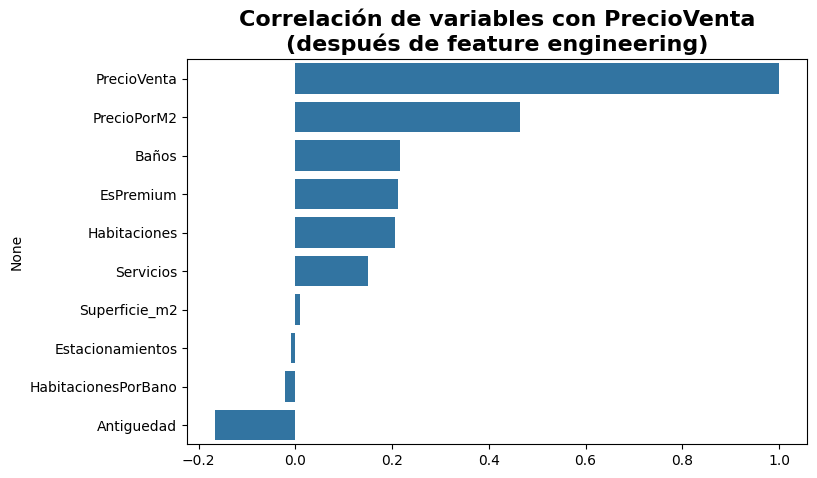

In [ ]:
# Visualización
plt.figure(figsize=(8,5))
sb.barplot(x=corr_target.values, y=corr_target.index)
plt.title("Correlación de variables con PrecioVenta\n(después de feature engineering)", fontsize=16, fontweight="bold")
plt.show()

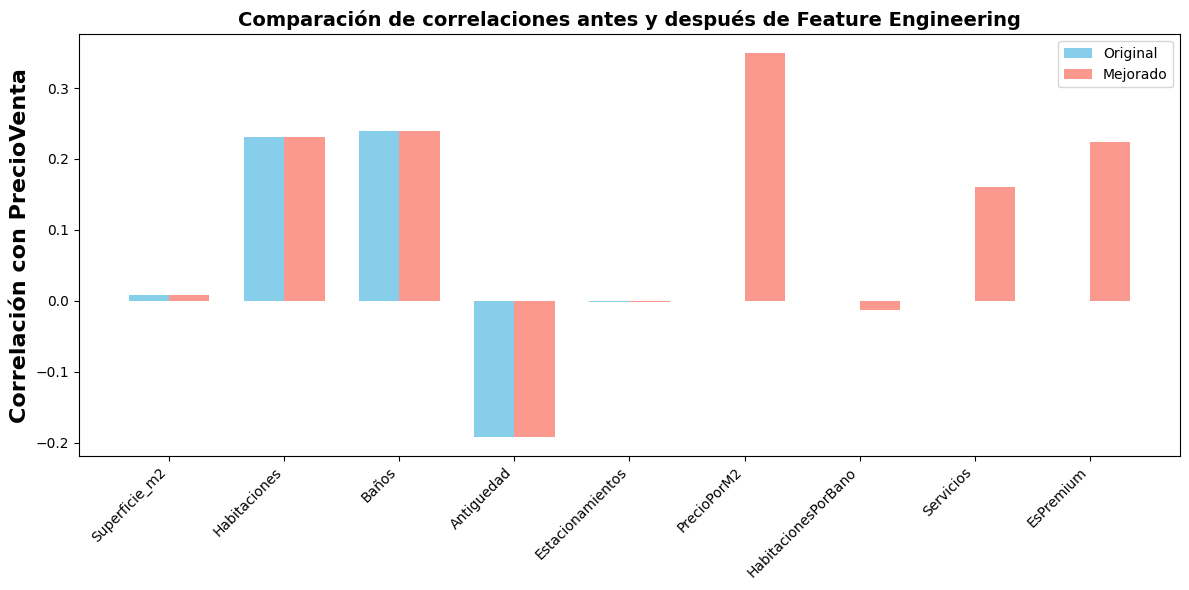

In [ ]:
# Correlaciones del modelo original

num_features_original = ["Superficie_m2", "Habitaciones", "Baños", "Antiguedad", "Estacionamientos"]
corr_original = data[num_features_original + ["PrecioVenta"]].corr()
corr_orig_target = corr_original["PrecioVenta"].sort_values(ascending=False)

# Correlaciones del modelo mejorado
data_fe = crear_features(data.copy())  # Aplicamos feature engineering
num_features_fe = ["Superficie_m2", "Habitaciones", "Baños", "Antiguedad", "Estacionamientos",
                   "PrecioPorM2", "HabitacionesPorBano", "Servicios", "EsPremium"]
corr_fe = data_fe[num_features_fe + ["PrecioVenta"]].corr()
corr_fe_target = corr_fe["PrecioVenta"].sort_values(ascending=False)

# Variables y correlaciones
features = num_features_original + ["PrecioPorM2", "HabitacionesPorBano", "Servicios", "EsPremium"]

# Correlaciones originales (para las variables que existían)
corr_orig_values = [corr_orig_target.get(f, 0) for f in features]
# Correlaciones mejoradas (para todas las features, si no existía antes, se pone 0)
corr_fe_values = [corr_fe_target.get(f, 0) for f in features]

# Posiciones de las barras
x = np.arange(len(features))
width = 0.35  # ancho de barra

plt.figure(figsize=(12,6))
plt.bar(x - width/2, corr_orig_values, width, label='Original', color='skyblue')
plt.bar(x + width/2, corr_fe_values, width, label='Mejorado', color='salmon', alpha=0.8)

# Etiquetas y aspecto visual del gráfico
plt.xticks(x, features, rotation=45, ha='right')
plt.ylabel('Correlación con PrecioVenta', fontsize=16, fontweight="bold")
plt.title('Comparación de correlaciones antes y después de Feature Engineering',
          fontsize=14, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Crea DataFrame con los resultados de las métricas
data_resultados = pd.DataFrame({
    "Métrica": list(resultado_inicial.keys()),
    "Modelo Original": list(resultado_inicial.values()),
    "Modelo Mejorado": list(resultado_final.values())
})
data_resultados.round(2)

,Métrica,Modelo Original,Modelo Mejorado
0,RMSE,28142.88,24313.73
1,R2,0.18,0.39
2,MAE,17469.26,14818.52
3,MSLE,0.39,0.30


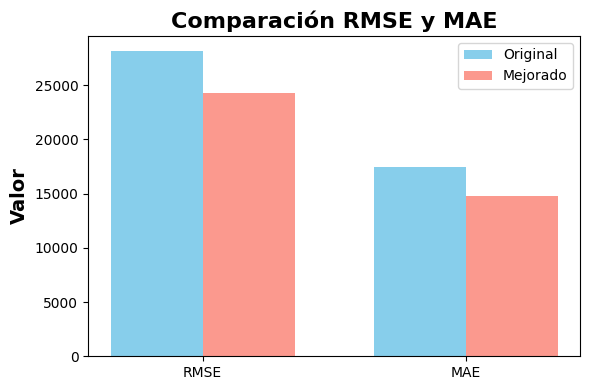

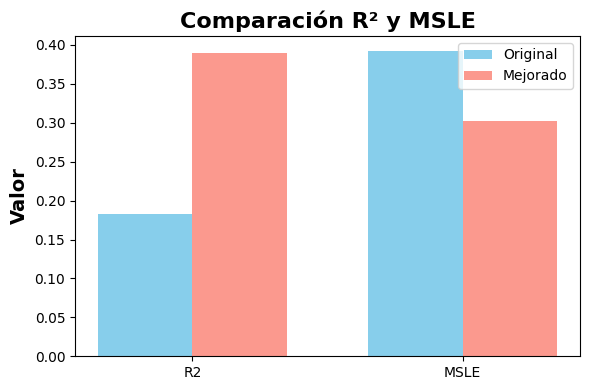

In [ ]:
# Separa las métricas porque tienen escalas distintas
metricas_grandes = ["RMSE", "MAE"]
metricas_pequenas = ["R2", "MSLE"]

# Filtrar valores
valores_orig_grandes = [resultado_inicial[metrica] for metrica in metricas_grandes]
valores_mej_grandes  = [resultado_final[metrica] for metrica in metricas_grandes]

valores_orig_peq = [resultado_inicial[metrica] for metrica in metricas_pequenas]
valores_mej_peq  = [resultado_final[metrica] for metrica in metricas_pequenas]

x_grandes = np.arange(len(metricas_grandes))
x_peq = np.arange(len(metricas_pequenas))
width = 0.35

# Gráfico RMSE y MAE
plt.figure(figsize=(6,4))
plt.bar(x_grandes - width/2, valores_orig_grandes, width, label="Original", color="skyblue")
plt.bar(x_grandes + width/2, valores_mej_grandes, width, label="Mejorado", color="salmon", alpha=0.8)
plt.xticks(x_grandes, metricas_grandes)
plt.ylabel("Valor", fontsize=14, fontweight="bold")
plt.title("Comparación RMSE y MAE", fontsize=16, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico R2 y MSLE
plt.figure(figsize=(6,4))
plt.bar(x_peq - width/2, valores_orig_peq, width, label="Original", color="skyblue")
plt.bar(x_peq + width/2, valores_mej_peq, width, label="Mejorado", color="salmon", alpha=0.8)
plt.xticks(x_peq, metricas_pequenas)
plt.ylabel("Valor", fontsize=14, fontweight="bold")
plt.title("Comparación R² y MSLE", fontsize=16, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()



✅ **Comentarios**

▶ `RMSE` y `MAE` más bajos en el modelo mejorado muestran que las predicciones son más precisas.

▶ $R^2$ más alto indica que el modelo mejorado explica más variabilidad del precio de la vivienda.

▶ `MSLE` más bajo refuerza que la predicción de valores grandes (viviendas caras) mejoró.